In [1]:
"""
Reference: https://www.drivendata.co/blog/predict-pm25-benchmark/

pyhdf appears to be more powerful than gdal, so it may be worth adopting some of the 
methods used here for working with hdf files.

Additionally, the tutorial shows how to make a masked numpy array, which allows us to work
with sparse arrays? (I'm not sure how this works yet.)

Finally, the tutorial explains how to align AOD data with coordinates. This could let us
make some useful model features, like local weather conditions, etc.

"""

import pandas as pd
from datetime import datetime
from osgeo import gdal
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from dateutil import parser
import matplotlib.pyplot as plt
import os



# from pathlib import Path
# import random
# from typing import Dict, List, Union

# from cloudpathlib import S3Path
import geopandas as gpd
# import rasterio

# DATA_PATH = Path.cwd().parent / "data"
# RAW = DATA_PATH / "raw"
# INTERIM = DATA_PATH / "interim"

In [2]:
pm_md = pd.read_csv(
    "pm25_satellite_metadata.csv",
    parse_dates=["time_start", "time_end"],
    index_col=0
)

grid_md = pd.read_csv(
    "grid_metadata.csv",
    index_col=0
)


maiac_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "train")].copy()
maiac_md.shape
print(maiac_md['time_start']['20180201T191000_maiac_la_0.hdf'])
pm_md.keys()
print(grid_md)

2018-02-01 17:25:00+00:00
                    location             tz  \
grid_id                                       
1X116                 Taipei    Asia/Taipei   
1Z2W7                  Delhi  Asia/Calcutta   
3S31A    Los Angeles (SoCAB)      Etc/GMT+8   
6EIL6                  Delhi  Asia/Calcutta   
7334C                  Delhi  Asia/Calcutta   
78V83                  Delhi  Asia/Calcutta   
7F1D1                  Delhi  Asia/Calcutta   
8KNI6                  Delhi  Asia/Calcutta   
90BZ1                 Taipei    Asia/Taipei   
90S79                  Delhi  Asia/Calcutta   
9Q6TA                 Taipei    Asia/Taipei   
A2FBI    Los Angeles (SoCAB)      Etc/GMT+8   
A7UCQ                  Delhi  Asia/Calcutta   
AZJ0Z                  Delhi  Asia/Calcutta   
C7PGV                  Delhi  Asia/Calcutta   
CPR0W                  Delhi  Asia/Calcutta   
D72OT                  Delhi  Asia/Calcutta   
D7S1G                  Delhi  Asia/Calcutta   
DHO4M    Los Angeles (SoCAB)      

In [3]:
#Playing around with datasets

from pyhdf.SD import SD, SDC, SDS
import pyproj


hdf = SD('train/20180201T191000_maiac_la_0.hdf')
print(hdf.info())
print(hdf.datasets())


(13, 8)
{'Optical_Depth_047': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 0), 'Optical_Depth_055': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 1), 'AOD_Uncertainty': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 2), 'FineModeFraction': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 3), 'Column_WV': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 4), 'AOD_QA': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 23, 5), 'AOD_MODEL': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 21, 6), 'Injection_Height': (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 5, 7), 'cosSZA': (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 8), 'cosVZA': (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 9), 'RelAZ': (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'

In [4]:
blue_band_AOD = hdf.select("Optical_Depth_047")
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
print(
f"""Dataset name: {name}
Number of dimensions: {num_dim}
Shape: {shape}
Data type: {types}
Number of attributes: {num_attr}"""
)

Dataset name: Optical_Depth_047
Number of dimensions: 3
Shape: [4, 1200, 1200]
Data type: 22
Number of attributes: 6


In [5]:
blue_band_AOD.get()

array([[[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [    21,     21,     21, ..., -28672, -28672, -28672],
        [    22,     21,     21, ..., -28672, -28672, -28672],
        [    24,     22,     21, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [   

In [6]:
calibration_dict = blue_band_AOD.attributes()
calibration_dict

{'long_name': 'AOD at 0.47 micron',
 'scale_factor': 0.001,
 'add_offset': 0.0,
 'unit': 'none',
 '_FillValue': -28672,
 'valid_range': [-100, 5000]}

In [7]:
raw_attr = hdf.attributes()["StructMetadata.0"]
group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
# print(group_1)

hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except:
        pass

hdf_metadata

{'GROUP': 'MergedFields',
 'END_GROUP': 'MergedFields',
 'GridName': 'grid1km',
 'XDim': 1200,
 'YDim': 1200,
 'UpperLeftPointMtrs': (-11119505.196667, 4447802.078667),
 'LowerRightMtrs': (-10007554.677, 3335851.559),
 'Projection': 'GCTP_SNSOID',
 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 'SphereCode': -1,
 'GridOrigin': 'HDFE_GD_UL',
 'OBJECT': 'DataField_8',
 'DimensionName': 'Orbits',
 'Size': 4,
 'END_OBJECT': 'DataField_8',
 'DataFieldName': 'Injection_Height',
 'DataType': 'DFNT_FLOAT32',
 'DimList': ('Orbits', 'YDim', 'XDim')}

In [8]:
# Note that coordinates are provided in meters
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}
alignment_dict

{'upper_left': (-11119505.196667, 4447802.078667),
 'lower_right': (-10007554.677, 3335851.559),
 'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}

In [9]:
"""
DATA PROCESSING

"""

'\nDATA PROCESSING\n\n'

In [10]:
# Loop over orbits to apply the attributes
def calibrate_data(dataset: SDS, shape: list[int], calibration_dict: dict):
    """Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        data = (
            (data - calibration_dict["add_offset"]) *
            calibration_dict["scale_factor"]
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD



In [11]:
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)
corrected_AOD

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [0.021, 0.021, 0.021, ..., --, --, --],
         [0.022, 0.021, 0.021, ..., --, --, --],
         [0.024, 0.022, 0.021, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [0.073, 0.065, 0.053, ..., --, --, --],
         [0.062, 0.057, 0.051000000000000004, ..., --, --, --],
         [0.056, 0.048, 0.041, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, -

In [12]:
pd.DataFrame(corrected_AOD.ravel(), columns=['AOD']).describe()

,AOD
count,1.203568e+06
mean,9.204344e-02
std,6.629422e-02
min,0.000000e+00
25%,4.500000e-02
50%,7.200000e-02
75%,1.220000e-01
max,5.940000e-01


In [13]:
"""

Aligning AOD data with real world coordinates


"""


def create_meshgrid(alignment_dict: dict, shape: list[int]):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

xv, yv = create_meshgrid(alignment_dict, shape)

In [14]:
from pyproj import CRS, Proj
from typing import Union

# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat



# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

In [15]:
def convert_array_to_df(
    corrected_arr: np.ma.MaskedArray,
    lat:np.ndarray,
    lon: np.ndarray,
    granule_id: str,
    crs: CRS,
    total_bounds: np.ndarray = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

gdf = convert_array_to_df(corrected_AOD, lat, lon, '20180201T191000_maiac_la_0.hdf', wgs84_crs)
print(gdf.shape)
gdf.head(3)

(1203568, 4)


,granule_id,orbit,geometry,value
0,20180201T191000_maiac_la_0.hdf,0,POINT (-110.79078 35.36280),0.110
1,20180201T191000_maiac_la_0.hdf,0,POINT (-110.78956 35.35446),0.076
2,20180201T191000_maiac_la_0.hdf,0,POINT (-110.28947 35.28774),0.112


In [16]:
"""

Some more helpful functions from the tutorial


"""

def create_calibration_dict(data: SDS):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()


def create_alignment_dict(hdf: SD):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [17]:
"""

Importing HDF data and creating a set of raw hdf files.


"""

train_labels = pd.read_csv("train_labels_100.csv") # Smallest subset
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train']
print(satellite_metadata)
raw_hdf_set = set(satellite_metadata['granule_id'])


                          granule_id                time_start  \
0     20180201T191000_maiac_la_0.hdf  2018-02-01T17:25:00.000Z   
1     20180202T195000_maiac_la_0.hdf  2018-02-02T18:05:00.000Z   
2     20180203T203000_maiac_la_0.hdf  2018-02-03T17:10:00.000Z   
3     20180204T194000_maiac_la_0.hdf  2018-02-04T17:55:00.000Z   
4     20180205T202000_maiac_la_0.hdf  2018-02-05T17:00:00.000Z   
...                              ...                       ...   
4255  20201227T071500_maiac_dl_0.hdf  2020-12-27T05:25:00.000Z   
4256  20201228T062000_maiac_dl_0.hdf  2020-12-28T06:10:00.000Z   
4257  20201229T070000_maiac_dl_0.hdf  2020-12-29T05:15:00.000Z   
4258  20201230T060500_maiac_dl_0.hdf  2020-12-30T05:55:00.000Z   
4259  20201231T065000_maiac_dl_0.hdf  2020-12-31T05:00:00.000Z   

                       time_end product location  split  \
0     2018-02-01 19:10:00+00:00   maiac       la  train   
1     2018-02-02 19:50:00+00:00   maiac       la  train   
2     2018-02-03 20:30:00+00:0

In [128]:
list(grid_md.location.keys())

['1X116',
 '1Z2W7',
 '3S31A',
 '6EIL6',
 '7334C',
 '78V83',
 '7F1D1',
 '8KNI6',
 '90BZ1',
 '90S79',
 '9Q6TA',
 'A2FBI',
 'A7UCQ',
 'AZJ0Z',
 'C7PGV',
 'CPR0W',
 'D72OT',
 'D7S1G',
 'DHO4M',
 'DJN0F',
 'E2AUK',
 'E5P9N',
 'FRITQ',
 'GAC6R',
 'GJLB2',
 'GVQXS',
 'H96P6',
 'HANW9',
 'HM74A',
 'IUMEZ',
 'KW43U',
 'KZ9W9',
 'NE7BV',
 'P8JA5',
 'PG3MI',
 'PJNW1',
 'PW0JT',
 'QJHW4',
 'S77YN',
 'SZLMT',
 'UC74Z',
 'VBLD0',
 'VR4WG',
 'VXNN3',
 'VYH7U',
 'WT52R',
 'WZNCR',
 'X5DKW',
 'XJF9O',
 'XNLVD',
 'YHOPV',
 'ZF3ZW',
 'ZP1FZ',
 'ZZ8JF']

In [151]:
from shapely.geometry import Point, Polygon

"""

Everything here is original code that uses the functions from the tutorial.

within(): taken from https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html

Make_Submatrix(): A function which takes raw AOD matrix and a Grid ID of interest as input and outputs a submatrix 
of AOD values which are inside this grid point (5km by 5km).

Currently, Make_Submatrix() only returns the number of pixels in the AOD matrix are within the location determined
by Grid ID.

The rest of the code in this cell runs extremely slowly, but this is because we are running it for all possible 
combinations of HDF file and Grid ID. When we actually use these functions to run a model on a given Grid ID and 
datetime, we will first filter the set of HDF files such that we only search through HDF files with matching city 
and matching datetime.

"""

# poly_dict = {}

# for gridID in list(grid_md.location.keys()):
#     poly = Make_Poly(grid_md['wkt'][gridID])
#     poly_dict[gridID] = poly

# print(poly_dict[gridID].bounds)

#Helper function
def Make_Poly(polyString):
    poly_coords = []
    for string in polyString.split(','):
        split_string = string.split(' ')
        if split_string[0] == 'POLYGON':
            split_string = split_string[1:]
            split_string[0] = str(split_string[0])[2:]
    #         print(tuple(float(x) for x in split_string))
        elif split_string[0] == '':
            split_string = split_string[1:]
        if split_string[1][-2] == ')':
            split_string[1] = split_string[1][0:-2]
        poly_coords.append(tuple(float(x) for x in split_string))

    return Polygon(poly_coords)



#Main function
def Make_Submatrix(corrected_AOD, lon, lat, alignment_dict, grid_md, gridID):
#     xv, yv = create_meshgrid(alignment_dict, shape)
#     lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    poly = Make_Poly(grid_md['wkt'][gridID])
    return_list = []
    for band in range(len(corrected_AOD)):
#         print('here 1')
    
        
        counter = 0
        triples_array = []
#         counter_i = 0
        for i in range(len(corrected_AOD[0])):
            if lat[i,0] > poly.bounds[3]:
                continue
                
            if lat[i,0] < poly.bounds[1]:
                continue
    
            for j in range(len(corrected_AOD[0][0])):
                if lon[i,j] > poly.bounds[2]:
                    continue
                p1 = Point(lon[i,j], lat[i,j]) 
    #             print(p1, poly)
                if(p1.within(poly)):
                    triples_array.append((i, j, corrected_AOD[band,i,j]))
                    counter+=1
                
        print(counter)   
                
#         print('here 2')
                
        if len(triples_array) == 0:
            continue

        temp_array = np.zeros((10,10))
        temp_array = np.ma.masked_array(temp_array, mask=np.ones((10,10)))

        i_array = [x[0] for x in triples_array]
        j_array = [x[1] for x in triples_array]
        min_i = min(i_array)
        min_j = min(j_array)

        

        for triple in triples_array:
            if triple[2] is np.ma.masked:
                pass
    #             return_array[triple[0]-min_i, triple[1]-min_j] = 'masked!!!'
            else:
                temp_array[triple[0]-min_i, triple[1]-min_j] = triple[2]
        return_list.append(temp_array)
#         print('here 3')

#     number_of_bands_returned = len(return_list)
    return return_list 
    
#     if counter > 0:
#         print(counter)
            

    
    #     print(tuple(float(x) for x in split_string))
#     print(triples_array)
#     for i in range(3):
#         plt.imshow(corrected_AOD[i])
#         plt.show()
    
    
# for hdf_filename in raw_hdf_set:
#     print(hdf_filename)
#     filepath = 'train/' + hdf_filename
#     raw_hdf = SD(filepath)
    
#     alignment_dict = create_alignment_dict(raw_hdf)
# #     print(alignment_dict['upper_left'], alignment_dict['lower_right'])
    
#     blue_band_AOD = raw_hdf.select("Optical_Depth_047")
#     name, num_dim, shape, types, num_attr = blue_band_AOD.info()
#     calibration_dict = create_calibration_dict(blue_band_AOD)
#     corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)
    
#     xv, yv = create_meshgrid(alignment_dict, shape)
#     lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    
#     for gridID in grid_md['wkt'].keys():
#         Make_Submatrix(corrected_AOD, lon, lat, alignment_dict, grid_md, gridID)
    

In [140]:
#Note that each AOD_array in array_of_AOD_arrays should be a precalculated subarray corresponding to grid id
def collect_features(array_of_AOD_arrays, area_per_subarray):
    
#     print('checkpoint 1')
    
    total_values = len(array_of_AOD_arrays)*area_per_subarray
#     print(total_values, 'values')
    
    all_values = np.zeros((total_values))
    all_values = np.ma.masked_array(all_values, mask=np.ones((total_values)))
    
#     print('checkpoint 2')
    
    counter = 0
    for AOD_array in array_of_AOD_arrays:
#         print('checkpoint 2.5')
        for row in AOD_array:
            for value in row:
#                 print('checkpoint 2.6', value)
                if not (value is np.ma.masked):
#                     print('checkpoint 2.7')
                    all_values[counter] = value
                    counter+=1
#                     print(all_values)
            
#     print('checkpoint 3')
    
    mean = np.ma.mean(all_values)
    minimum = np.ma.min(all_values)
    maximum = np.ma.max(all_values)
    std = np.ma.std(all_values)
    summ = np.ma.sum(all_values)
    
    print('done')
    return(mean, minimum, maximum, std, summ)
    
    

In [20]:
print(train_labels.keys())
print(satellite_metadata['location'].unique())
print(grid_metadata['location'].unique())
print(alignment_dict)
print(calibration_dict)
print(satellite_metadata)
print(grid_metadata)

Index(['datetime', 'grid_id', 'value'], dtype='object')
['la' 'tpe' 'dl']
['Taipei' 'Delhi' 'Los Angeles (SoCAB)']
{'upper_left': (-11119505.196667, 4447802.078667), 'lower_right': (-10007554.677, 3335851.559), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}
{'long_name': 'AOD at 0.47 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
                          granule_id                time_start  \
0     20180201T191000_maiac_la_0.hdf  2018-02-01T17:25:00.000Z   
1     20180202T195000_maiac_la_0.hdf  2018-02-02T18:05:00.000Z   
2     20180203T203000_maiac_la_0.hdf  2018-02-03T17:10:00.000Z   
3     20180204T194000_maiac_la_0.hdf  2018-02-04T17:55:00.000Z   
4     20180205T202000_maiac_la_0.hdf  2018-02-05T17:00:00.000Z   
...                              ...                       ...   
4255  20201227T071500_maiac_dl_0.hdf  2020-12-27T05:25:00.000Z   
4256  20201228T062000_maiac_d

In [166]:
def get_features(train_labels, satellite_metadata, grid_id_list, training):
    features = []
    for i in range(len(train_labels)):
        
        print(i)
        print(features)

        satellite_metadata_cut = satellite_metadata

        grid_id = train_labels['grid_id'][i]
        j = grid_id_list.index(grid_id)
        location = grid_metadata['location'][j]
        tz = grid_metadata['tz'][j]
        datetime = pd.to_datetime(
            train_labels['datetime'][j],
            format="%Y%m%dT%H:%M:%S",
            utc=True
        )
        polygon = grid_metadata['wkt'][j]
    #     print(grid_id, datetime, location, timezone, polygon)

        if location == 'Delhi':
            satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'dl'].copy()
        elif location == 'Los Angeles (SoCAB)':
            satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'la'].copy()
        elif location == 'Taipei':
            satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'tpe'].copy()

    #     print(location, tz)
    #     print(len(satellite_metadata_cut))
    #     print(len(satellite_metadata))

        valid_datetime = [None]*len(satellite_metadata_cut)
        satellite_metadata_cut.reset_index(drop=True, inplace=True) # ensure indexes pair with number of rows
    #     count = 0
        for index, row in satellite_metadata_cut.iterrows():

            datetime1 = pd.to_datetime((row['time_start']), format="%Y%m%dT%H:%M:%S", 
                                    utc=True) #.tz_localize(None).tz_localize(tz)
            datetime2 = pd.to_datetime(row['time_end'], format="%Y%m%dT%H:%M:%S", 
                                                utc=True) #.tz_localize(None).tz_localize(tz)

    #         print(index, datetime1.tzinfo)
    #         print(datetime2.tzinfo)

    #         print(datetime1, datetime, datetime2)

            truth1 = (datetime <= datetime2)
            truth2 = datetime2 <= datetime + timedelta(hours=24)
    #         count+=1
    #         print(count)
            valid_datetime[index] = (truth1 & truth2)
    #         if valid_datetime[index] == True:
    #             print('Yay!')



        satellite_metadata_cut['valid_datetime'] = valid_datetime
        satellite_metadata_cut = satellite_metadata_cut[satellite_metadata_cut['valid_datetime'] == True]
    #     print(len(satellite_metadata_cut), location)
    #     print(satellite_metadata_cut['granule_id'])
        raw_hdf_set = list(satellite_metadata_cut['granule_id']) #Note for now we are only including the first HDF;
                                                              #Should make a function later which chooses the best HDF
                                                              #File and the best band.


        print(raw_hdf_set, location)
        print('next:')

    # """
        list_of_all_AOD_arrays = []
        for hdf_filename in raw_hdf_set:
    #         print(hdf_filename)
            
            if training:
                filepath = 'train/' + hdf_filename
            else:
                filepath = 'test/' + hdf_filename
    #         print(filepath)
            raw_hdf = SD(filepath)

            alignment_dict = create_alignment_dict(raw_hdf)
        #     print(alignment_dict['upper_left'], alignment_dict['lower_right'])

            blue_band_AOD = raw_hdf.select("Optical_Depth_047")
            name, num_dim, shape, types, num_attr = blue_band_AOD.info()
            calibration_dict = create_calibration_dict(blue_band_AOD)
            corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)

            xv, yv = create_meshgrid(alignment_dict, shape)
            lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

    #         print('made it here1')

            temp = Make_Submatrix(corrected_AOD, lon, lat, alignment_dict, grid_md, grid_id)
    #         print('made it here2')
            if len(temp) == 0:
                continue
            for AOD_array in temp:
                list_of_all_AOD_arrays.append(AOD_array)

        if list_of_all_AOD_arrays == 0:
            if training:
                features.append(np.array((np.nan, np.nan, np.nan, np.nan, np.nan)))
            else:
                features.append(np.array((0, 0, 0, 0, 0)))
        else:
            features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))
    #         print('made it here3')

    # """
    print(features)
    return features

In [159]:
#Getting data to train the model
from datetime import datetime, timedelta


features = []
train_labels = pd.read_csv("train_labels.csv") # Smallest subset
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train'].copy()


grid_id_list = list(grid_metadata['grid_id'])
# for i in range(len(train_labels)):
    
#     satellite_metadata_cut = satellite_metadata
    
#     grid_id = train_labels['grid_id'][i]
#     j = grid_id_list.index(grid_id)
#     location = grid_metadata['location'][j]
#     tz = grid_metadata['tz'][j]
#     datetime = pd.to_datetime(
#         train_labels['datetime'][j],
#         format="%Y%m%dT%H:%M:%S",
#         utc=True
#     )
#     polygon = grid_metadata['wkt'][j]
# #     print(grid_id, datetime, location, timezone, polygon)
    
#     if location == 'Delhi':
#         satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'dl'].copy()
#     elif location == 'Los Angeles (SoCAB)':
#         satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'la'].copy()
#     elif location == 'Taipei':
#         satellite_metadata_cut = satellite_metadata[satellite_metadata['location'] == 'tpe'].copy()
        
# #     print(location, tz)
# #     print(len(satellite_metadata_cut))
# #     print(len(satellite_metadata))
        
#     valid_datetime = [None]*len(satellite_metadata_cut)
#     satellite_metadata_cut.reset_index(drop=True, inplace=True) # ensure indexes pair with number of rows
# #     count = 0
#     for index, row in satellite_metadata_cut.iterrows():
        
#         datetime1 = pd.to_datetime((row['time_start']), format="%Y%m%dT%H:%M:%S", 
#                                 utc=True) #.tz_localize(None).tz_localize(tz)
#         datetime2 = pd.to_datetime(row['time_end'], format="%Y%m%dT%H:%M:%S", 
#                                             utc=True) #.tz_localize(None).tz_localize(tz)
        
# #         print(index, datetime1.tzinfo)
# #         print(datetime2.tzinfo)

# #         print(datetime1, datetime, datetime2)
        
#         truth1 = (datetime <= datetime2)
#         truth2 = datetime2 <= datetime + timedelta(hours=24)
# #         count+=1
# #         print(count)
#         valid_datetime[index] = (truth1 & truth2)
# #         if valid_datetime[index] == True:
# #             print('Yay!')
    
    
    
#     satellite_metadata_cut['valid_datetime'] = valid_datetime
#     satellite_metadata_cut = satellite_metadata_cut[satellite_metadata_cut['valid_datetime'] == True]
# #     print(len(satellite_metadata_cut), location)
# #     print(satellite_metadata_cut['granule_id'])
#     raw_hdf_set = list(satellite_metadata_cut['granule_id']) #Note for now we are only including the first HDF;
#                                                           #Should make a function later which chooses the best HDF
#                                                           #File and the best band.
    
    
#     print(raw_hdf_set, location)
#     print('next:')
    
# # """
#     list_of_all_AOD_arrays = []
#     for hdf_filename in raw_hdf_set:
# #         print(hdf_filename)
#         filepath = 'train/' + hdf_filename
# #         print(filepath)
#         raw_hdf = SD(filepath)

#         alignment_dict = create_alignment_dict(raw_hdf)
#     #     print(alignment_dict['upper_left'], alignment_dict['lower_right'])

#         blue_band_AOD = raw_hdf.select("Optical_Depth_047")
#         name, num_dim, shape, types, num_attr = blue_band_AOD.info()
#         calibration_dict = create_calibration_dict(blue_band_AOD)
#         corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)

#         xv, yv = create_meshgrid(alignment_dict, shape)
#         lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
        
# #         print('made it here1')

#         temp = Make_Submatrix(corrected_AOD, lon, lat, alignment_dict, grid_md, grid_id)
# #         print('made it here2')
#         if len(temp) == 0:
#             continue
#         for AOD_array in temp:
#             list_of_all_AOD_arrays.append(AOD_array)
            
#     if list_of_all_AOD_arrays == 0:
#         features.append(np.array((np.nan, np.nan, np.nan, np.nan, np.nan)))
#     else:
#         features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))
# #         print('made it here3')
    
# # """
# print(features)
features = get_features(train_labels, satellite_metadata, grid_id_list, True)
# Etc/GMT+8
    
    

# print(train_labels[train_labels['grid_id'] == '1X116']) demonstration of the fact that grids are repeated at 
#different datetimes.

    

['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
done
['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
done
['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
21
21
21
21
done
['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
20
20
20
20
done
['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
22
22
22
22
done
['20180201T191000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
23
23
23
23
done
['20180202T195000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
done
['20180202T195000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
17
17
17
17
done
['20180202T195000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
18
18
18
18
done
['20180202T195000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:


KeyboardInterrupt: 

In [22]:
import pickle
    
pickle.dump( features, open( "save1.p", "wb" ) )
print(features)



[array([0.08363158, 0.063     , 0.107     , 0.01132631, 3.178     ]), array([0.08105263, 0.059     , 0.106     , 0.01330205, 3.08      ]), array([0.07797297, 0.036     , 0.133     , 0.03143289, 2.885     ]), array([0.10215385, 0.052     , 0.161     , 0.02714778, 3.984     ]), array([0.12309091, 0.093     , 0.163     , 0.02256991, 5.416     ]), array([0.13273913, 0.109     , 0.166     , 0.01513768, 3.053     ]), array([0.12613158, 0.077     , 0.192     , 0.03005361, 4.793     ]), array([0.099     , 0.025     , 0.134     , 0.02732947, 1.98      ]), array([0.223     , 0.139     , 0.46      , 0.09415147, 3.568     ]), array([0.17009091, 0.096     , 0.226     , 0.03558972, 7.484     ]), array([0.09357895, 0.047     , 0.124     , 0.01710591, 3.556     ]), array([0.0768    , 0.        , 0.139     , 0.03463081, 2.304     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), a

In [82]:
#Making the model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
import tensorflow as tf



features_cut = features.copy()

        


labels_array = np.array(train_labels.value)
cut_labels_array = list(labels_array[0:227].copy())

i = 0
while( i < len(features_cut)):
    print(features_cut[i][0])
    if np.isnan(features_cut[i][0]):
        features_cut.pop(i)
        cut_labels_array.pop(i)
    else:
        i+=1
        
print(len(features_cut))
print(len(cut_labels_array))

def make_model():

    model = Sequential()
    model.add(Dense(13, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = make_model()
model.summary()
model.fit(X, Y, epochs=1000, batch_size=10)

# estimator = KerasRegressor(build_fn=make_model, nb_epoch=100, batch_size=5, verbose=0)

# X = np.array(features_cut)
# Y = np.array(cut_labels_array)

# kfold = KFold(n_splits=10)
# results = cross_val_score(estimator, X, Y, n_jobs=1)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


0.08363157894736843
0.08105263157894738
0.07797297297297297
0.10215384615384615
0.1230909090909091
0.1327391304347826
0.1261315789473684
0.099
0.22300000000000003
0.1700909090909091
0.09357894736842105
0.07680000000000001
nan
nan
nan
nan
nan
nan
nan
0.8204347826086957
0.6804117647058824
0.7850000000000001
0.5046904761904761
0.7068333333333333
0.572375
0.5551489361702128
0.688741935483871
0.746741935483871
0.29331578947368425
0.34060714285714283
0.2911666666666667
nan
nan
nan
nan
nan
nan
nan
0.8204347826086957
0.6804117647058824
0.7850000000000001
0.5046904761904761
0.7068333333333333
0.5551489361702128
0.688741935483871
0.746741935483871
0.29331578947368425
0.34060714285714283
0.2911666666666667
0.08363157894736843
0.08105263157894738
0.07797297297297297
0.10215384615384615
0.1230909090909091
0.1327391304347826
0.1261315789473684
0.099
0.22300000000000003
0.1700909090909091
0.09357894736842105
0.07680000000000001
nan
nan
nan
nan
nan
nan
nan
0.8204347826086957
0.6804117647058824
0.78500

18/18 [==============================] - 0s 420us/step - loss: 1467.7393
Epoch 47/1000
18/18 [==============================] - 0s 422us/step - loss: 1447.6515
Epoch 48/1000
18/18 [==============================] - 0s 424us/step - loss: 1434.9009
Epoch 49/1000
18/18 [==============================] - 0s 409us/step - loss: 1426.8481
Epoch 50/1000
18/18 [==============================] - 0s 409us/step - loss: 1419.9778
Epoch 51/1000
18/18 [==============================] - 0s 399us/step - loss: 1416.2477
Epoch 52/1000
18/18 [==============================] - 0s 436us/step - loss: 1414.0226
Epoch 53/1000
18/18 [==============================] - 0s 382us/step - loss: 1412.2311
Epoch 54/1000
18/18 [==============================] - 0s 398us/step - loss: 1411.1326
Epoch 55/1000
18/18 [==============================] - 0s 415us/step - loss: 1410.2440
Epoch 56/1000
18/18 [==============================] - 0s 429us/step - loss: 1411.6542
Epoch 57/1000
18/18 [==============================] - 0s

18/18 [==============================] - 0s 400us/step - loss: 1388.8374
Epoch 140/1000
18/18 [==============================] - 0s 425us/step - loss: 1390.1337
Epoch 141/1000
18/18 [==============================] - 0s 429us/step - loss: 1388.9166
Epoch 142/1000
18/18 [==============================] - 0s 412us/step - loss: 1389.2355
Epoch 143/1000
18/18 [==============================] - 0s 430us/step - loss: 1388.9817
Epoch 144/1000
18/18 [==============================] - 0s 414us/step - loss: 1388.0151
Epoch 145/1000
18/18 [==============================] - 0s 446us/step - loss: 1387.3904
Epoch 146/1000
18/18 [==============================] - 0s 431us/step - loss: 1387.2181
Epoch 147/1000
18/18 [==============================] - 0s 438us/step - loss: 1387.8812
Epoch 148/1000
18/18 [==============================] - 0s 385us/step - loss: 1388.5547
Epoch 149/1000
18/18 [==============================] - 0s 397us/step - loss: 1386.7975
Epoch 150/1000
18/18 [=========================

18/18 [==============================] - 0s 486us/step - loss: 1364.0468
Epoch 233/1000
18/18 [==============================] - 0s 441us/step - loss: 1365.6321
Epoch 234/1000
18/18 [==============================] - 0s 427us/step - loss: 1365.2354
Epoch 235/1000
18/18 [==============================] - 0s 429us/step - loss: 1365.3326
Epoch 236/1000
18/18 [==============================] - 0s 439us/step - loss: 1364.1216
Epoch 237/1000
18/18 [==============================] - 0s 407us/step - loss: 1365.4188
Epoch 238/1000
18/18 [==============================] - 0s 411us/step - loss: 1365.2327
Epoch 239/1000
18/18 [==============================] - 0s 412us/step - loss: 1364.0282
Epoch 240/1000
18/18 [==============================] - 0s 430us/step - loss: 1363.2012
Epoch 241/1000
18/18 [==============================] - 0s 465us/step - loss: 1363.5020
Epoch 242/1000
18/18 [==============================] - 0s 416us/step - loss: 1361.8896
Epoch 243/1000
18/18 [=========================

18/18 [==============================] - 0s 427us/step - loss: 1340.9484
Epoch 326/1000
18/18 [==============================] - 0s 410us/step - loss: 1339.3577
Epoch 327/1000
18/18 [==============================] - 0s 428us/step - loss: 1340.3126
Epoch 328/1000
18/18 [==============================] - 0s 398us/step - loss: 1340.1143
Epoch 329/1000
18/18 [==============================] - 0s 427us/step - loss: 1339.0642
Epoch 330/1000
18/18 [==============================] - 0s 451us/step - loss: 1339.2469
Epoch 331/1000
18/18 [==============================] - 0s 403us/step - loss: 1338.3242
Epoch 332/1000
18/18 [==============================] - 0s 430us/step - loss: 1338.2114
Epoch 333/1000
18/18 [==============================] - 0s 431us/step - loss: 1337.9453
Epoch 334/1000
18/18 [==============================] - 0s 394us/step - loss: 1337.4457
Epoch 335/1000
18/18 [==============================] - 0s 451us/step - loss: 1337.6323
Epoch 336/1000
18/18 [=========================

18/18 [==============================] - 0s 424us/step - loss: 1316.7476
Epoch 419/1000
18/18 [==============================] - 0s 418us/step - loss: 1317.0066
Epoch 420/1000
18/18 [==============================] - 0s 411us/step - loss: 1314.2560
Epoch 421/1000
18/18 [==============================] - 0s 407us/step - loss: 1315.5692
Epoch 422/1000
18/18 [==============================] - 0s 410us/step - loss: 1314.7278
Epoch 423/1000
18/18 [==============================] - 0s 417us/step - loss: 1314.6176
Epoch 424/1000
18/18 [==============================] - 0s 392us/step - loss: 1315.9515
Epoch 425/1000
18/18 [==============================] - 0s 400us/step - loss: 1314.8096
Epoch 426/1000
18/18 [==============================] - 0s 410us/step - loss: 1315.4485
Epoch 427/1000
18/18 [==============================] - 0s 395us/step - loss: 1316.8031
Epoch 428/1000
18/18 [==============================] - 0s 401us/step - loss: 1314.0988
Epoch 429/1000
18/18 [=========================

18/18 [==============================] - 0s 403us/step - loss: 1290.7473
Epoch 512/1000
18/18 [==============================] - 0s 422us/step - loss: 1291.8979
Epoch 513/1000
18/18 [==============================] - 0s 410us/step - loss: 1294.6365
Epoch 514/1000
18/18 [==============================] - 0s 399us/step - loss: 1288.8339
Epoch 515/1000
18/18 [==============================] - 0s 410us/step - loss: 1290.1204
Epoch 516/1000
18/18 [==============================] - 0s 392us/step - loss: 1288.2203
Epoch 517/1000
18/18 [==============================] - 0s 392us/step - loss: 1288.2979
Epoch 518/1000
18/18 [==============================] - 0s 407us/step - loss: 1287.9268
Epoch 519/1000
18/18 [==============================] - 0s 424us/step - loss: 1286.4669
Epoch 520/1000
18/18 [==============================] - 0s 442us/step - loss: 1287.9893
Epoch 521/1000
18/18 [==============================] - 0s 427us/step - loss: 1286.7462
Epoch 522/1000
18/18 [=========================

18/18 [==============================] - 0s 398us/step - loss: 1263.9849
Epoch 605/1000
18/18 [==============================] - 0s 422us/step - loss: 1262.6041
Epoch 606/1000
18/18 [==============================] - 0s 417us/step - loss: 1263.5409
Epoch 607/1000
18/18 [==============================] - 0s 399us/step - loss: 1261.9586
Epoch 608/1000
18/18 [==============================] - 0s 396us/step - loss: 1262.9432
Epoch 609/1000
18/18 [==============================] - 0s 402us/step - loss: 1262.3838
Epoch 610/1000
18/18 [==============================] - ETA: 0s - loss: 2233.77 - 0s 441us/step - loss: 1262.5249
Epoch 611/1000
18/18 [==============================] - 0s 416us/step - loss: 1261.7675
Epoch 612/1000
18/18 [==============================] - 0s 405us/step - loss: 1261.8473
Epoch 613/1000
18/18 [==============================] - 0s 422us/step - loss: 1261.6198
Epoch 614/1000
18/18 [==============================] - 0s 437us/step - loss: 1261.4697
Epoch 615/1000
18/18 

Epoch 697/1000
18/18 [==============================] - 0s 416us/step - loss: 1240.3701
Epoch 698/1000
18/18 [==============================] - 0s 406us/step - loss: 1238.7472
Epoch 699/1000
18/18 [==============================] - 0s 427us/step - loss: 1238.8483
Epoch 700/1000
18/18 [==============================] - 0s 433us/step - loss: 1237.3901
Epoch 701/1000
18/18 [==============================] - 0s 414us/step - loss: 1236.9661
Epoch 702/1000
18/18 [==============================] - 0s 416us/step - loss: 1237.7235
Epoch 703/1000
18/18 [==============================] - 0s 400us/step - loss: 1237.1686
Epoch 704/1000
18/18 [==============================] - 0s 430us/step - loss: 1236.9651
Epoch 705/1000
18/18 [==============================] - 0s 404us/step - loss: 1236.5099
Epoch 706/1000
18/18 [==============================] - 0s 422us/step - loss: 1236.9550
Epoch 707/1000
18/18 [==============================] - 0s 389us/step - loss: 1236.4614
Epoch 708/1000
18/18 [==========

18/18 [==============================] - 0s 366us/step - loss: 1217.9442
Epoch 791/1000
18/18 [==============================] - 0s 400us/step - loss: 1213.0793
Epoch 792/1000
18/18 [==============================] - 0s 432us/step - loss: 1220.1313
Epoch 793/1000
18/18 [==============================] - 0s 381us/step - loss: 1213.2397
Epoch 794/1000
18/18 [==============================] - 0s 420us/step - loss: 1212.1588
Epoch 795/1000
18/18 [==============================] - 0s 398us/step - loss: 1212.4587
Epoch 796/1000
18/18 [==============================] - 0s 423us/step - loss: 1211.5826
Epoch 797/1000
18/18 [==============================] - 0s 391us/step - loss: 1210.3141
Epoch 798/1000
18/18 [==============================] - 0s 415us/step - loss: 1211.6038
Epoch 799/1000
18/18 [==============================] - 0s 399us/step - loss: 1210.6471
Epoch 800/1000
18/18 [==============================] - 0s 409us/step - loss: 1210.6169
Epoch 801/1000
18/18 [=========================

18/18 [==============================] - 0s 403us/step - loss: 1185.8824
Epoch 884/1000
18/18 [==============================] - 0s 412us/step - loss: 1186.4991
Epoch 885/1000
18/18 [==============================] - 0s 432us/step - loss: 1190.8486
Epoch 886/1000
18/18 [==============================] - 0s 405us/step - loss: 1187.3044
Epoch 887/1000
18/18 [==============================] - 0s 392us/step - loss: 1185.2902
Epoch 888/1000
18/18 [==============================] - 0s 388us/step - loss: 1185.9919
Epoch 889/1000
18/18 [==============================] - 0s 405us/step - loss: 1185.6603
Epoch 890/1000
18/18 [==============================] - 0s 411us/step - loss: 1184.6345
Epoch 891/1000
18/18 [==============================] - 0s 399us/step - loss: 1185.0709
Epoch 892/1000
18/18 [==============================] - 0s 382us/step - loss: 1184.7872
Epoch 893/1000
18/18 [==============================] - 0s 404us/step - loss: 1183.2466
Epoch 894/1000
18/18 [=========================

18/18 [==============================] - 0s 414us/step - loss: 1159.4182
Epoch 977/1000
18/18 [==============================] - 0s 414us/step - loss: 1161.0499
Epoch 978/1000
18/18 [==============================] - 0s 415us/step - loss: 1161.3435
Epoch 979/1000
18/18 [==============================] - 0s 428us/step - loss: 1161.3691
Epoch 980/1000
18/18 [==============================] - 0s 375us/step - loss: 1160.3429
Epoch 981/1000
18/18 [==============================] - 0s 397us/step - loss: 1159.9851
Epoch 982/1000
18/18 [==============================] - 0s 411us/step - loss: 1160.5610
Epoch 983/1000
18/18 [==============================] - 0s 415us/step - loss: 1159.4685
Epoch 984/1000
18/18 [==============================] - 0s 411us/step - loss: 1158.8726
Epoch 985/1000
18/18 [==============================] - 0s 385us/step - loss: 1158.4808
Epoch 986/1000
18/18 [==============================] - 0s 410us/step - loss: 1157.9391
Epoch 987/1000
18/18 [=========================

In [117]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = model.predict(np.array(features_cut))
print(mean_squared_error(predicted, Y))
r2_score(predicted, Y)


1154.1287177313234


0.5873456021965002

In [118]:
pickle.dump( model, open( "model1.p", "wb" ) )

INFO:tensorflow:Assets written to: ram://41937174-8843-4691-a700-08b99f437415/assets


In [167]:
#testing the model, first getting features

test_labels = pd.read_csv("submission_format.csv") # Smallest subset
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'test'].copy()


grid_id_list = list(grid_metadata['grid_id'])

features_test = get_features(test_labels, satellite_metadata, grid_id_list, False) 

0
[]
['20170108T022500_maiac_tpe_0.hdf', '20170108T040000_maiac_tpe_0.hdf'] Taipei
next:
24
24
24
0
0
0
done
1
[array([nan, nan, nan, nan, nan])]
['20170109T030500_maiac_tpe_0.hdf', '20170109T030500_maiac_tpe_1.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


24
24
24
24
0
0
0
done
2
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170110T035000_maiac_tpe_0.hdf', '20170110T021000_maiac_tpe_0.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


0
0
0
0
25
25
25
done
3
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170111T025500_maiac_tpe_0.hdf', '20170111T025500_maiac_tpe_1.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


25
25
25
25
0
0
0
done
4
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170111T025500_maiac_tpe_0.hdf', '20170111T025500_maiac_tpe_1.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


24
24
24
24
0
0
0
done
5
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170107T194500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


19
19
19
19
done
6
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170108T202500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
19
done
7
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ])]
['20170108T202500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
21
21
21
21
21
done
8
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ])]
['20170108T202500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
20
20
20
20
20
done
9
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]

/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170109T193000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
23
23
23
23
done
11
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170109T193000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
done
12
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170109T193000_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
17
17
17
17
done
13
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170110T201500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
18
18
18
18
done
14
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170110T201500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
22
22
22
22
done
15
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170110T201500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
19
19
19
19
done
16
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170110T201500_maiac_la_0.hdf'] Los Angeles (SoCAB)
next:
18
18
18
18
done
17
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


['20170108T022500_maiac_tpe_0.hdf', '20170108T040000_maiac_tpe_0.hdf'] Taipei
next:
24
24
24
0
0
0
done
18
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170109T030500_maiac_tpe_0.hdf', '20170109T030500_maiac_tpe_1.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


24
24
24
24
0
0
0
done
19
[array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([0.12861538, 0.056     , 0.191     , 0.04211347, 3.344     ]), array([0.06861905, 0.032     , 0.122     , 0.03140363, 2.882     ]), array([0.11519444, 0.054     , 0.298     , 0.06880036, 4.147     ]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan])]
['20170110T035000_maiac_tpe_0.hdf', '20170110T021000_maiac_tpe_0.hdf'] Taipei
next:


/var/folders/s9/bqp3gwh57sv7rgc2_ynsbcdm0000gn/T/ipykernel_84259/551230634.py:108: UserWarning: Warning: converting a masked element to nan.
  features.append(np.array(collect_features(list_of_all_AOD_arrays, 100)))


KeyboardInterrupt: 

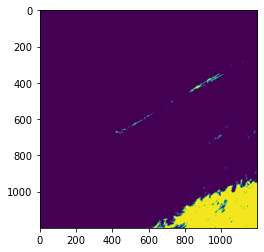

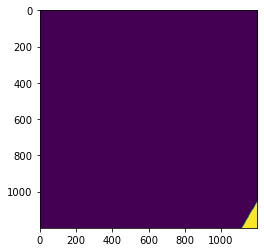

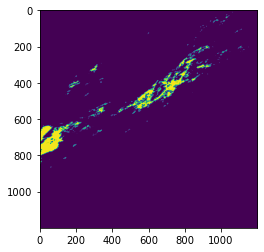

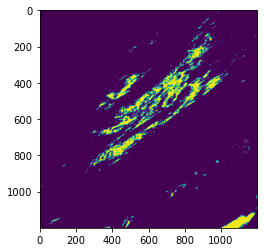

48


In [184]:
hdf = SD('test/20170109T193000_maiac_la_0.hdf')
hdf47 = hdf.select(0)
for i in range(4):
    plt.imshow(hdf47.get()[i])
    plt.show()
print(hdf47.get()[0][1199, 1199])